<a href="https://colab.research.google.com/github/aminehd/AminehTechnicalWritings/blob/main/notebookes/LinearRegressionMatrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Outline
- Load data in repo
- Introduction (Purpose + scope)
- Body
  - Linear regression is solving linear equations approximately.
     - Matrix notation of linear regression equations.
     - build X matrix with loaded data
     - Solve " X β = y"
    - Why $\widehat{\beta}$ and not just $\beta$

  - How to solve uncertain set of linear equations?
  - The line fitting.
  - Connection between method of least squares and the distribution of error terms.
- Conclusion:
- Appendix: Some linear algebra
  - questions
  - switch to another view: column space
  - revisit two questions
  - Go back a bit, what if no solution, what about projection ...
  - rank of X, stuff about the projecting
  - what if it has solution


##Git Setup

In [ ]:
import google.colab
repo_path = 'AminehTechnicalWritings'
!git -C $repo_path pull origin || git clone https://github.com/aminehd/AminehTechnicalWritings/ $repo_path
local_clone = '/content/' + repo_path
!git config --global user.email "amineh.dadsetan@gmail.com"
!git config --global user.name "Amineh Dadsetan"

fatal: cannot change to 'AminehTechnicalWritings': No such file or directory
Cloning into 'AminehTechnicalWritings'...
remote: Enumerating objects: 407, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (174/174), done.
remote: Total 407 (delta 169), reused 152 (delta 89), pack-reused 141
Receiving objects: 100% (407/407), 3.79 MiB | 15.11 MiB/s, done.
Resolving deltas: 100% (248/248), done.


In [ ]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '/content/AminehTechnicalWritings/src')
import sampling_utils as su
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
population = su.get_population(local_clone + '/data/population.npz')
population.shape

(300000, 2)

## Introduction
In this notebook, I would like to go through the linear regression concepts. The way I came across the concept in differnt books goes like this.
First some introduction of statistics concepts of how the data looks like, whats a predictor, what is a response, and the goal that is to train from a **sample** data set.
 And then there is some matrix notations plus loss functions and instruction on how to use them to reach the goal which is training the model based on given **sample**.
 Ocasionally, at the end, there might be a word or two on how Maximum liklihood or Best Linear Unbiased Estimator  is relevent to the subject.

So you see, it starts with statistics, then turns to linear algebra and some analysis, and finally a lot of probability that sounds very uncalled for.

In this notebook, I attempt to teach the linear regression, while separating all this major ideas from different fields of study. I also try to implement python function that serves as a mechanism to talk about all this mathematical abstractions. My hope is to give the audience tools to answer their questions about all this concepts using the python utilities . Hopefully, I can build more tools around them to teach even more complex Machine Learning concepts.

I think the key point to understand linear regression and methods built around it, is to pause and think about difference of **populataion data set** and a given **sample data set**. Let's play around with the two concept with our data. ⏸

I have wrote some utility function that helps you build a sampler around given population.
Once you built a sampler from population, you can fix the set of predictors (`set_sample_xs`). Finally you can use `sample_response` to sample `y`s with replacement.
You can think of it as a experiment in which the predictor is age and outcome is their credit score. Before starting the experminet you know how many people and from what ages you would like to run experiment on. Just knowing the ages (predictor) is not enought since there is so many people with same age thus so many credit scores (response) that can be used as training set.  So what you need to do is to sample actual people of the given ages to study their credit scores.








In [ ]:

sampler = su.PopulationSampler(population)
x_samp_index, x_samples = sampler.set_sample_xs(100)
resp = np.array(list(sampler.sample_response()))
x, y = resp[:, 0], resp[:, 1]


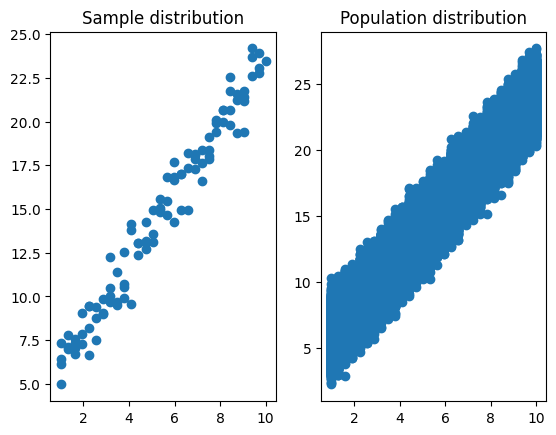

In [ ]:
fix, axes = plt.subplots(ncols=2)
# sample[:,0], sample[:,1]
axes[0].scatter(x, y)
axes[0].set_title('Sample distribution')
axes[1].set_title('Population distribution')
axes[1].scatter(population[:,0], population[:,1]);



The random data from  previous notebook follows the assumption of linear regression. This assumes that if you subtract a linear combination of predictors from the response, the result will have a standard normal distribution. Hence, you can fit a linear model to a given sample.


The fact is that we either don't have access to the whole population, or it is computationally too difficult to fit linear regression on the whole population set.


Because of that we pull a set of samples, (sample data set) and fit the model on it. But how do we know that the sample follows the assumption of linear regression as well? What if the sample data set is a horrible representetive of population data set and not random at all? The way to ensure is to sample with replacement. Doing so lets us make assuption about distribution of error for the given sample.

Although we can make some assumption on the sample data set, it is not gonna be the same assumption as we do for the whole population. That is we say the **linear regression coefficients** for a sample is an estimate for linear regression coefficients for population data set. ($\beta$ vs $\widehat\beta$. More on that [here](https://colab.research.google.com/github/aminehd/AminehTechnicalWritings/blob/main/notebookes/LinearRegressionMatrix.ipynb#scrollTo=cwhNfPNNkFAH) )



### Linear regression is solving linear equations approximately

Plotting the responses versus predictors reveals a noticeable linear pattern, both in the sample and population datasets. In our case it faintly resembles a line in 2D space that can be described with two numbers: slope and intercept.

Fitting a linear model to data is similar to solving n equations with p variables, with the goal of finding the coefficient.  There is  one small difference: fitting linear model is approximate, while solving system of linear equations is exact solutions.


Going back to history of linear regression, the first use of fitting linear models to observed data originated from the field of astronomy. Scientists attempted to determine fixed parameters related to the positions and motions of celestial bodies based on astronomical data, under the assumption of a linear model.
However, these observations were subject to errors, leading to instances where the equations had no solutions.

Their trick was to introduce an error term, ensuring that the equations would always have at least one solution.

Likewise, we can add an error term to the right side of our equations, ensuring that the system always has a solution. However, the caveat is that multiple solutions will exists, each with different error term values and we need to find a criteria that which set of errors are better overall. Or alternatively we can decide  which solution is more likely to be the correct one, if we have a distribution on the error terms.  But hold off on that that part and let's focus on the system of linear equations for now.



The equations for a given sample of size n looks likes:
$$
\begin{align}
y_1 &= \beta_1 x_{11} + \cdots + \beta_p x_{1p} + \beta_0 + \epsilon_1\\
y_2 &= \beta_1 x_{21} + \cdots + \beta_p x_{2p} + \beta_0 + \epsilon_2\\
&\vdots \\
y_n &= \beta_1 x_{n1} + \cdots + \beta_p x_{np}  + \beta_0 + \epsilon_n
\end{align}
$$


At this point the problem statement is more forma. In other word, asking to find the best line that fits the sample data is not as clear as asking to solve a set of linear equations. However, we haven't yet talked about how to solve them.

Before delving into solving the linear equtions, lets see some algebraic interpretation of this.




### Matrix notation of linear regression.

Samples are a set of tuples. To use linear algebra, we can switch to their notations, which is vectors and matrices.
Each predictor can be viewed as a row vector, (e.g, $x_i = [ x_{i,1}, ..., x_{ip}]^T$.)  . It means predictors are n vecotres each of p dimensions. You can even stack them on top of each other: 🦣
$$
y =
\begin{bmatrix}
y_1 \\
y_2 \\
\vdots \\
y_n
\end{bmatrix}
=
\begin{bmatrix}
x_{11} & x_{12} & \ldots & x_{1p} \\
x_{21} & x_{22} & \ldots & x_{2p} \\
\vdots & \vdots & \ddots & \vdots \\
x_{n1} & x_{n2} & \ldots & x_{np}
\end{bmatrix}
\begin{bmatrix}
\beta_1 \\
\vdots \\
\beta_p
\end{bmatrix}
+
\begin{bmatrix}
\beta_0 \\
\beta_0 \\
\vdots \\
\beta_0
\end{bmatrix}
+ ϵ$$

You can see that the intercept is a vector that is n-times repeatition of $\beta_0$ ( a bit awkward 🤷).

A tiny trick helps putting $\beta_0$ with rest of $\beta_i$'s. At least help visually. 🎉 🧙
$$
y =
\begin{bmatrix}
1 & x_{11} & x_{12} & \ldots & x_{1p} \\
1 & x_{21} & x_{22} & \ldots & x_{2p} \\
\vdots &\vdots & \vdots & \ddots & \vdots \\
1 & x_{n1} & x_{n2} & \ldots & x_{np}
\end{bmatrix}
\begin{bmatrix}
\beta_0 \\
\vdots \\
\beta_p \\
\end{bmatrix}
+ ϵ
$$

For ease, we refer to the above augmented matrix as $\tilde{x}$:
$$
\tilde{X} = \begin{bmatrix}
1 & x_{11} & x_{12} & \ldots & x_{1p} \\
1 & x_{21} & x_{22} & \ldots & x_{2p} \\
\vdots &\vdots & \vdots & \ddots & \vdots \\
1 & x_{n1} & x_{n2} & \ldots & x_{np}
\end{bmatrix}
$$
Just to make it a bit easier, we rename $\tilde{X}$ to X again. So by referring to $X$ we reffer to the augmented X.



### build X matrix

HERE!!! construct X from the data. Play with it




Lets build the X matrix


In [ ]:

X = np.c_[np.ones(100), x]
print(f"Shape of X: {X.shape}")
print(f"Rank of X: {np.linalg.matrix_rank(X)}")



Shape of X: (100, 2)
Rank of X: 2


###  Solve " X $\widehat{\beta}$ + ϵ= y"




Putting all observation in a matrix, yields one line equation that is equivalent to solving the system of linear equations  that is :
$$ \textbf{X} \widehat{\beta} + \epsilon = y$$

Solving such equation would have been a standard procedure, if there were no error term $\epsilon$ or uncertanty in other words.

By a solution to $ \textbf{X} \widehat{\beta} + \epsilon = y$, we mean finding a value for $\widehat{\beta}$ and for $\epsilon$.  But probably there is way too many answers for them. How to find the best? The simplest idea is to find one that has min value for $||\epsilon|| =||\mathbf{X} \widehat{\beta} - y||$.

There are several ways to find $\widehat{\beta}$ such that it minimizes $||\mathbf{X} \widehat{\beta} - y||$. For example taking partial deravatives in respect to $x_j$'s and find where all of them are 0.


 my favorite approach is the one that uses some linear algebraic concepts such as projection. This is how it goes:

The minimum value of $||\textbf{X} \widehat{\beta}  - y||$ is the distance of y from it's projection onto column space of X. Lets call such projection $\widehat{y}$. Thus $||\textbf{X} \widehat{\beta}||$ has minimum value when  

$$\textbf{X} \widehat{\beta}  = \widehat{y}$$
$\textbf{X}$ and $\widehat{y}$ are known and the goal is to find unkonwn $\widehat{\beta}$. This one is guaranteed to have solutions.

. So all you need is to project y to columns space of $\mathbf{X}$ and then solve a simple matrix equation that is guaranteed to have an answer.  


Long story short, there exists unique solution for $\widehat{\beta}$ that minimizes $||X \widehat{\beta} - y||$ and that is:
$$(X^T X)^{-1} X^T y$$

We denote the $(X^TX)^{-1} X^T$  by $X^+$

For a full proof of the procedure you can take a look at the [appendix](https://colab.research.google.com/github/aminehd/AminehTechnicalWritings/blob/main/notebookes/LinearRegressionMatrix.ipynb#scrollTo=KWHMu8ZeHkst).  

Lets inspect the $X$ and $X^TX$ and finally $X^+$ matrix. We have built matrix `X` by putting together the all predictors in the sample. Shape of X is `(100,2)`. Which means it is not square matrix thus not inversible. How about rank of `X`?


In [ ]:
print(f"{X.shape=}")
rank_X = np.linalg.matrix_rank(X)
print(f"{rank_X=}")

X.shape=(100, 2)
rank_X=2


HERE!!!!Let's do the same for $X^TX$:

In [ ]:
XTX = X.T @ X
print(f"{XTX.shape=}")
rank_XTX = np.linalg.matrix_rank(XTX)
print(f"{rank_XTX=}")

XTX.shape=(2, 2)
rank_XTX=2


In [ ]:
X_plus = X @ np.linalg.inv(np.transpose(X) @ X) @ np.transpose(X)
X_plus.shape
y.shape
y_hat = X_plus @ y

Based on the matrix notation, we can construct the matrix X:

At this point we claim that `y_hat` is in the column space of X. In fact we also claim that `y_hat` is the prediction obtained my method of least square.



In [ ]:
b, residuals, rank, s = np.linalg.lstsq(X, y, rcond=None)

estimate_y = b[0] + b[1] * x
print(f"L2 norm of difference of estimat_y with y_hat: {np.sum(np.square(estimate_y - y_hat)):.2e}")


L2 norm of difference of estimat_y with y_hat: 8.94e-27


As you can see the  norm of the distance of the estimated_y and y_hat is  almost 0 (8.94e-27). So to find estimated response, all you need is multiply `X_plus` by `y`.   Similarly you can  HERE!!!!!!!!




HERE!!!
we arrive at:
$${\displaystyle {\widehat {\beta }}=(X^{\operatorname {T} }X)^{-1}X^{\operatorname {T} }y}$$
HERE!!! Why the books calculate $\hat{\beta}$ instead of $\{beta}$


### Why $\widehat{\beta}$ and not just $\beta$
I would like to have a quick note on why we set out to find $\widehat{\beta}$ and not the $\beta$. $\beta$ is the population regression coefficient whereas $\widehat{\beta}$ is the sample regression coefficient. By solving the equation for a given sample, we find values for  $\beta$ and $\epsilon$. The $\widehat{}$ sign basically tells us that there is no guarantee that by following a procedure on a given sample we are going to find the exact $\beta$ simply because we see a portion of whole data. But keep in mind a good procedure is one that calculates unbiased $\widehat{\beta}$ over all possible samples (meaning their average equals the poulation regression coefficients). 🎩

### what motivates $||X \widehat\beta - y ||$ as a loss function


If you like to see more reasoning behind why we picked $||Ax -b ||$ as lose function, or as a function to minimize, I can add some more to it.In context of linear regression, $\widehat{ \beta}$ is called [**ordinary least squares estimator**](https://en.wikipedia.org/wiki/Gauss%E2%80%93Markov_theorem).



One way to justify the loss function as $||X \widehat\beta - y ||$, is to use the concept of **Best Linear Unbiased Estimator**.

The idea in the procedure is that instead of aiming to find real value for $\beta$, we aim for finding an estimator called $\widehat\beta$. Because of linear assumptions, we are specifically looking for a linear estimator.

So what do we mean by linear? It means $\widehat\beta$ is linear in $y$ which means you can write $\widehat\beta$ in the form of a matrix $A$ time $y$ (e.g., $\widehat\beta = A y$). Goal would be to find matrix A.

Even with the assumption of linearity, there is going to be a lot of such estimator. Another assumpotion is being unbiased. HERE!!! explain unbiased
HERE!!! explain the assumptions on $\epsilon$





HERE!!!!!!!!!find proof that uses maximum liklihood and the dist of error to justify minimization of AX-b. HERE!!!!!!sketch of proofTo find the most likely y, under the condition of normal error,  which yields to minimizing  $||Ax -b ||$ ( It turns loss function to a liklihood function https://www.cs.princeton.edu/courses/archive/fall18/cos324/files/mle-regression.pdf)

Statisticians typically motivate ordinary least squares by the [principle of maximum likelihood](https://en.wikipedia.org/wiki/Gauss%E2%80%93Markov_theorem)  because of this feature.

HERE!!! use the loaded data to show XTX effect.

### Line fitting

while it is nice to visualize the data point using second view, we mainly use the first view to solve the system of equations. Let's find such hyperplane for our sample data points ( or n vectors of 2-dimensional )

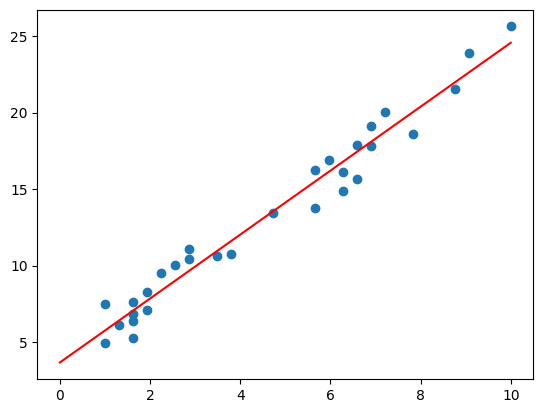

In [ ]:
# fit regression for sample of shape (30, 2)
slope, intercept = np.polyfit(sample[:, 0], sample[:,1], 1)
fig, ax = plt.subplots()
ax.scatter(sample[:, 0], sample[:, 1])
ax.plot(np.linspace(0, 10, 40), slope * np.linspace(0, 10, 40) + intercept, 'r')

## Connection between method of least squares and the Error terms

Without the epsilon term, finding the regression parameters (or $\beta_i$'s) looks like solving multiple linear equations and there is standard prodecures for it. But now what do we do with epsilon term.

Let's take a look into the history of it.

The method of least squares grew out of the fields of astronomy, as scientists tried to provide solutions to the challenges of navigating the Earth's oceans.

Their astronomical observations were in form of lots of equations with lots of variables. But observations always have error in them. So there was cases that these equation do not have any solution. However, they really wanted a solution.

Their trick was to add an error term, and expect that equations to always have some solution. Typically, multiple solutions exist, each with different error term values. The best solution is the one that minimizes the overall error.

How to define the criterion for overal error term? Which function of error do we want to minimize? One possible such funtion is the sum of squares of errors. The modthod that finds the linear regression coefficients by minimizing the sum of square of errors is called method of least squares. Nowdays, method of least squares is part of Regression, particularly it is one possible loss function.


The first clear and concise exposition of the method of least squares was published by [Legendre](https://en.wikipedia.org/wiki/Adrien-Marie_Legendre) in 1805.

However, In 1809 Carl Friedrich Gauss published his method of calculating the orbits of celestial bodies.This naturally led to a priority dispute with Legendre. However, to Gauss's credit, he went beyond Legendre and succeeded in connecting the method of least squares with the principles of probability and to the normal distribution. We'll see how the method gets linked to the probability distribution of errors.

But why method of least square is a good choice for finding the coefficients? the answer to this question depends on two things: firstly on the assumptions about error distribution, and secondly, on what are we looking for in a solution.  

By picking a criterion for solving the equations, in practice, we find a estimate $\hat{\beta_j}$ for $\beta_j$ in below equations. This estimate is a function of $X$ and $y$.

$$
\begin{align}
y_1 &= \beta_1 x_{11} + \cdots + \beta_p x_{1p} + \beta_0 + \epsilon_1\\
y_2 &= \beta_1 x_{21} + \cdots + \beta_p x_{2p} + \beta_0 + \epsilon_2\\
&\vdots \\
y_n &= \beta_1 x_{n1} + \cdots + \beta_p x_{np}  + \beta_0 + \epsilon_n
\end{align}
$$



If we decide to minimize the sum of least square of errors, the estimator $\hat{\beta}$ will be called **ordinary least squares estimator (OLS)** and is below function
$$
\beta_j =  (X^TX)^{-1}X^Ty
$$

⏰  Now, wait for it ..., it turns out that OLS is the **best unbiased linear estimator** or [BLUE](https://en.wikipedia.org/wiki/Gauss%E2%80%93Markov_theorem) under a few assumptions about the set of error random variables, $\epsilon_i$:
- They have mean zero: $E[\epsilon_i]= 0$
- They are homoscedastic, that is all have the same finite variance: $Var(\epsilon_i) = \sigma^2$ for all i and
- Distinct error terms uncorrelated: $Cov(\epsilon_i, \epsilon_j) = 0, \forall i \neq j.$

⭐ We can answer the question we asked a while ago: why method of least square is a good choice for finding the coefficients, specificaly when the error terms has a normal distribution?  Because under the assumption of normal distibution and uncorrelated error terms, the OLS estimator (that is result of using method of least squares) is going to be Best unbiased linear estimator or BLUE.

🔹 The term BLUE suggests that there are other good estimators. OLS is the best one among the linear and unbiased ones. The fact that OLS estimator is linear in term of y's is easy to verify.

However, we haven't explained what unbiased means.

Here is an observation that helps answer above question:

WHen there is no predictors and error follows normal distribution, mean of responses is what optimizes the sum of squared errors.
In that case $y = [y_1, ..., y_n]^T$ and we would like to find best $\beta_0$ to fit $y = \hat{\beta_0 }$. Then OLS would minimize $\sum{(y_i - \hat{\beta_0})^2}$.

If we use the $\hat{\beta_0}$ calculated for the sample to estimate the $\beta_0$ for the whole population or better to say the real y for population, this estimation is *unbiased*. It means on average we expect $\hat{\beta_0}$ to equal to ${\beta_0}$. Hence an unbiased estimator does not systemically over- or under-estimate the true value.

So basically when predictors are 0 dimensional,  benefit of using method of least square as loss function, estimators would be unbiased over all samples.


  In fact under the assumption of normally distributed errors, the least squares estimates have desirable properties such as being unbiased and having minimum variance among all linear estimators. That is one of the reasons that  method of least squares and normal distribution are tied together.
  
  



## Conclusion
We looked at linear regression problem in the form of solving multiple linear equations. Then we looked at two ways of interpreting a solution with matrixes (or linear spaces). Finally we contemplated on the error terms, method of least squares, and how the mothod is connected to the distribution of error terms.


  
  
This concludes this not book. Next notebook we try to look at the model coefficients ($\beta_i$'s ) as summary statistics defined on samples. You can also think of them as measures since samples are subsets.  

Then we look at  expected value of sample statistices over multiple sampling. Also we look at variance of stuff within sample, and variance of sample   stat over several samplings. This indeed is an intersting case when sample stat is defined to be the mean of sample.


These can help understand concept of Standard Error and F-test better.



## Appendix: Some linear algebra
As we said the minimum value of $||\textbf{X} \widehat{\beta}  - y||$ is the distance of y from it's projection onto column space of X. Lets say $\widehat{y}$ is the projection of $y$ onto column space of X. Thus $||\textbf{X} \widehat{\beta}||$ has minimum value when:  

$$\textbf{X} \widehat{\beta}  = \widehat{y}$$

So we ended up with a matrix equation that always has an answer. That is great. To find the least square solution, all we need to do is to find the projection $\widehat{y}$ and then solve the new equation.

Since we are going to work a lot with column space of X, lets denot it by $RAN_X$.

How can we project $y$ to columns space of $\mathbf{X}$?
 Turns out it really depends. For example if $\mathbf{X}$ is a square matrix, then every vector of right dimension is already on column space of $\mathbf{X}$.If $\mathbf{X}$ columns are orthonormal basis, $\mathbf{X}\mathbf{X}^T$ is desired projection.

Let's take a closer look

Since $X \widehat\beta$ is eqaul to image of $y$ on $RAN_X$. Thus $X\beta - y$ is prependicular to any column $x_i$ of $X$. That means
$${x_i}^T .(X \widehat\beta - y) = 0$$
For all $i$'s
stacking the ${x_i}^T$ on top of each other as rows yields:
$$
\begin{align}
X^T (X \widehat\beta - y) = 0 & \\
X^T X \widehat\beta = X^T y \tag{Norma Equation}
\end{align}
$$
Since $X^TX$ is a square matrix and we if it has non 0 determinant it is invertible (easy thing to check). We use this fact to solve the $\widehat\beta$
$$\widehat\beta = (X^TX)^{-1} X^T y$$

Few things to notice here. First of all, solution for $\widehat\beta$ only depends on $X$ and not on $y$ anymore. Secondly we did a lot of mind bending matrix calculation just to reach to **Normal equation** ? Also if why don't we just use inverted X instead of inverting  $X^T X$ ? Well a shallow answer might be because $X^T X$ is a square matrix.

HERE!!! GO through rest of stuff and delete maybe
HERE!!! read bilinear forms https://en.wikipedia.org/wiki/Change_of_basis





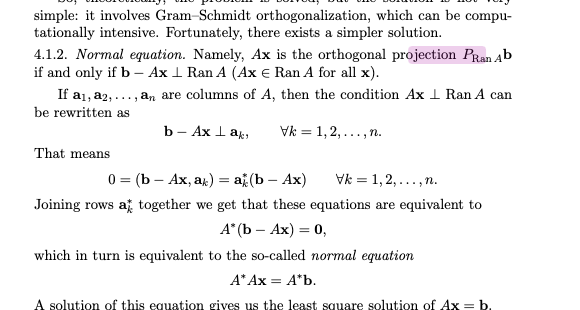








HERE!!!! read 5. Adjoint of a linear transformation (152/286). Fundamental subspaces revisited. for linalgdonewrong, before proceeding, maybe choose some excerise from it and work it out with data.
2.1. Orthogonal and orthonormal bases. (137/ 286)
4. Least square solution. Formula for the orthogonal projection

HERE!!!! make a line for $\mathbf{X}(\mathbf{X}^T\mathbf{X})^{-1}X^T$ and name it.
While $\mathbf{X}(\mathbf{X}^T\mathbf{X})^{-1}X^T y =  X \widehat{\beta}$ might have multiple solution, one trivial solution is $\hat{\beta} = (X^TX)^{-1}X^T y$ by removing X from the right and left side

HERE!!!(easier way to arrive at it?what if y is in column space of X? does it simplify? see with data)
 HERE!!!
**sources**
1. https://en.wikipedia.org/wiki/Projection_(linear_algebra)#Formulas
2. https://www-users.cse.umn.edu/~rejto/4242/4242_2final_sol3.pdf
3. https://math.stackexchange.com/questions/1816364/the-svd-solution-to-linear-least-squares-linear-system-of-equations


HERE!!! put all X(XTX)-1 craziness to here, **NAME** my important eqs for easier reference 🌨 First tag them with **(NAME=EXPANDED_MATRIX_EQ)**. ask chat how

HERE!!!! so what is the solution for $\widhat{beta}$???

Now lets sample a set and try these matrices.
Let's construct the  matrix X for the data we sampled. We can check some algebraic measures on matrix X then. I would suggest try to answer a few questions for yourself, such as
1. what is the shape of X?
2. what is the rank of X?